## IMPORTS

In [4]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_curve, roc_auc_score, classification_report,
    precision_score, recall_score, f1_score, confusion_matrix,
    precision_recall_curve, average_precision_score
)

In [5]:
# Set display options
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

## LOAD DAGSTER MATERIALIZED ASSETS

In [ ]:
def load_artifact(artifact_name: str, storage_dir="../tmp8400tun6/storage/"):
    """
    Load artifacts that were materialized by Dagster
    
    Args:
        artifact_name: Name of the asset (e.g., 'df_model_input', 'logistic_regression_model')
        storage_dir: Dagster storage directory
    """
    artifact_path = os.path.join(storage_dir, artifact_name)
    
    if not os.path.exists(artifact_path):
        print(f"Asset '{artifact_name}' not found at {artifact_path}")
        print(f"Make sure you've materialized this asset in Dagster UI first!")
        return None
    
    with open(artifact_path, 'rb') as fp:
        artifact = pickle.load(fp)
    
    print(f"Loaded: {artifact_name}")
    return artifact

## LOAD ALL THE MATERIALIZED ASSETS 

In [7]:
# Load raw data
core_data = load_artifact("core_data")
usage_info = load_artifact("usage_info")
customer_interactions = load_artifact("customer_interactions")

# Load engineered features
df_model_input = load_artifact("df_model_input")
feature_names = load_artifact("feature_names")

# Load trained models
logistic_regression_model = load_artifact("logistic_regression_model")
xgboost_model = load_artifact("xgboost_model")

# Load train/test splits
X_train = load_artifact("X_train")
X_test = load_artifact("X_test")
y_train = load_artifact("y_train")
y_test = load_artifact("y_test")
scaler = load_artifact("scaler")

# Load evaluation results
evaluate_lr = load_artifact("evaluate_logistic_regression")
evaluate_xgb = load_artifact("evaluate_xgboost")


✅ Loaded: core_data
✅ Loaded: usage_info
✅ Loaded: customer_interactions
✅ Loaded: df_model_input
✅ Loaded: feature_names
✅ Loaded: logistic_regression_model
✅ Loaded: xgboost_model
✅ Loaded: X_train
✅ Loaded: X_test
✅ Loaded: y_train
✅ Loaded: y_test
✅ Loaded: scaler
✅ Loaded: evaluate_logistic_regression
✅ Loaded: evaluate_xgboost


## EXPLORE THE MODEL INPUT DATA

In [8]:
if df_model_input is not None:
    print(f"Shape: {df_model_input.shape}")
    print(f"\nColumns: {list(df_model_input.columns)[:10]}...")
    print(f"\nFirst few rows:")
    print(df_model_input.head())
    
    print(f"\nTarget distribution:")
    print(df_model_input['has_done_upselling'].value_counts(normalize=True))

Shape: (100000, 48)

Columns: ['rating_account_id', 'customer_id', 'age', 'contract_lifetime_days', 'remaining_binding_days', 'has_special_offer', 'is_magenta1_customer', 'available_gb', 'gross_mrc', 'smartphone_brand']...

First few rows:
   rating_account_id customer_id  age  contract_lifetime_days  \
0             865702    3.161250   45                     813   
1             154152    4.220152   38                     847   
2             837792    4.308332   28                     675   
3             819351    3.842810   31                     183   
4             157550    2.656471   43                    1094   

   remaining_binding_days  has_special_offer  is_magenta1_customer  \
0                    -619                  0                     0   
1                      75                  1                     0   
2                     309                  0                     1   
3                     -18                  0                     1   
4                  

## FEATURE IMPORTANCE

In [9]:
if logistic_regression_model is not None:
    lr_model = logistic_regression_model['model']
    print(f"Logistic Regression Model: {type(lr_model)}")
    print(f"Number of features: {len(lr_model.coef_[0])}")
    
    # Show top features
    print("\nTop 10 Most Important Features (Logistic Regression):")
    feature_importance = logistic_regression_model['feature_importance']
    print(feature_importance.head(10))

if xgboost_model is not None:
    xgb_model = xgboost_model['model']
    print(f"\nXGBoost Model: {type(xgb_model)}")
    print(f"Number of features: {xgb_model.n_features_in_}")
    
    # Show top features
    print("\nTop 10 Most Important Features (XGBoost):")
    feature_importance = xgboost_model['feature_importance']
    print(feature_importance.head(10))

Logistic Regression Model: <class 'sklearn.linear_model._logistic.LogisticRegression'>
Number of features: 44

Top 10 Most Important Features (Logistic Regression):
                   feature  coefficient  abs_coefficient
11             used_gb_std     0.208310         0.208310
0                      age    -0.203764         0.203764
5             available_gb    -0.169285         0.169285
36            contract_new    -0.160372         0.160372
1   contract_lifetime_days    -0.148764         0.148764
8            used_gb_total    -0.142874         0.142874
7              used_gb_avg    -0.142874         0.142874
6                gross_mrc    -0.139804         0.139804
9              used_gb_min     0.137344         0.137344
29       is_out_of_binding     0.129799         0.129799

XGBoost Model: <class 'xgboost.sklearn.XGBClassifier'>
Number of features: 44

Top 10 Most Important Features (XGBoost):
                   feature  importance
5             available_gb    0.082364
29      

## VIEW MODEL PERFORMANCE

In [10]:

# Calculate training set performance for LR
if logistic_regression_model is not None and X_train is not None:
    lr_model = logistic_regression_model['model']
    lr_train_pred_proba = lr_model.predict_proba(X_train)[:, 1]
    lr_train_pred = lr_model.predict(X_train)
    lr_train_auc = roc_auc_score(y_train, lr_train_pred_proba) # type: ignore
    lr_train_pr_auc = average_precision_score(y_train, lr_train_pred_proba) # type: ignore
    
    lr_train_precision = precision_score(y_train, lr_train_pred) # type: ignore
    lr_train_recall = recall_score(y_train, lr_train_pred) # type: ignore
    lr_train_f1 = f1_score(y_train, lr_train_pred) # type: ignore
    lr_train_cm = confusion_matrix(y_train, lr_train_pred) # type: ignore

# Calculate training set performance for XGB
if xgboost_model is not None and X_train is not None:
    xgb_model = xgboost_model['model']
    xgb_train_pred_proba = xgb_model.predict_proba(X_train)[:, 1]
    xgb_train_pred = xgb_model.predict(X_train)
    xgb_train_auc = roc_auc_score(y_train, xgb_train_pred_proba) # type: ignore
    xgb_train_pr_auc = average_precision_score(y_train, xgb_train_pred_proba) # type: ignore
    
    xgb_train_precision = precision_score(y_train, xgb_train_pred) # type: ignore
    xgb_train_recall = recall_score(y_train, xgb_train_pred) # type: ignore
    xgb_train_f1 = f1_score(y_train, xgb_train_pred) # type: ignore
    xgb_train_cm = confusion_matrix(y_train, xgb_train_pred) # type: ignore

# Calculate test set PR AUC
if evaluate_lr is not None:
    lr_test_pr_auc = average_precision_score(y_test, evaluate_lr['probabilities']) # type: ignore

if evaluate_xgb is not None:
    xgb_test_pr_auc = average_precision_score(y_test, evaluate_xgb['probabilities']) # type: ignore

# Display results
if evaluate_lr is not None:
    print("\n" + "="*60)
    print("LOGISTIC REGRESSION PERFORMANCE")
    print("="*60)
    
    print("\nTRAINING SET:")
    print(f"ROC-AUC:    {lr_train_auc:.4f}") # type: ignore
    print(f"PR-AUC:     {lr_train_pr_auc:.4f}") # type: ignore
    print(f"Precision:  {lr_train_precision:.4f}") # type: ignore
    print(f"Recall:     {lr_train_recall:.4f}") # type: ignore
    print(f"F1 Score:   {lr_train_f1:.4f}") # type: ignore
    print("\nConfusion Matrix:")
    print(lr_train_cm) # type: ignore
    
    print("\nTEST SET:")
    print(f"ROC-AUC:    {evaluate_lr['roc_auc']:.4f}")
    print(f"PR-AUC:     {lr_test_pr_auc:.4f}") # type: ignore
    print(f"Precision:  {evaluate_lr['confusion_matrix'][1,1] / (evaluate_lr['confusion_matrix'][1,1] + evaluate_lr['confusion_matrix'][0,1]):.4f}")
    print(f"Recall:     {evaluate_lr['confusion_matrix'][1,1] / (evaluate_lr['confusion_matrix'][1,1] + evaluate_lr['confusion_matrix'][1,0]):.4f}")
    print(f"F1 Score:   {evaluate_lr['f1_score']:.4f}")
    print("\nConfusion Matrix:")
    print(evaluate_lr['confusion_matrix'])
    
    # Check for overfitting
    auc_diff = lr_train_auc - evaluate_lr['roc_auc'] # type: ignore
    pr_auc_diff = lr_train_pr_auc - lr_test_pr_auc # type: ignore
    print(f"\nTrain-Test ROC-AUC Difference: {auc_diff:.4f}")
    print(f"Train-Test PR-AUC Difference:  {pr_auc_diff:.4f}")
    if auc_diff > 0.05 or pr_auc_diff > 0.05:
        print("WARNING: Possible overfitting detected")
    else:
        print("Model generalizes well (minimal train-test gap)")

if evaluate_xgb is not None:
    print("\n" + "="*60)
    print("XGBOOST PERFORMANCE")
    print("="*60)
    
    print("\nTRAINING SET:")
    print(f"ROC-AUC:    {xgb_train_auc:.4f}") # type: ignore
    print(f"PR-AUC:     {xgb_train_pr_auc:.4f}") # type: ignore
    print(f"Precision:  {xgb_train_precision:.4f}") # type: ignore
    print(f"Recall:     {xgb_train_recall:.4f}") # type: ignore
    print(f"F1 Score:   {xgb_train_f1:.4f}") # type: ignore
    print("\nConfusion Matrix:")
    print(xgb_train_cm) # type: ignore
    
    print("\nTEST SET:")
    print(f"ROC-AUC:    {evaluate_xgb['roc_auc']:.4f}")
    print(f"PR-AUC:     {xgb_test_pr_auc:.4f}") # type: ignore
    print(f"Precision:  {evaluate_xgb['confusion_matrix'][1,1] / (evaluate_xgb['confusion_matrix'][1,1] + evaluate_xgb['confusion_matrix'][0,1]):.4f}")
    print(f"Recall:     {evaluate_xgb['confusion_matrix'][1,1] / (evaluate_xgb['confusion_matrix'][1,1] + evaluate_xgb['confusion_matrix'][1,0]):.4f}")
    print(f"F1 Score:   {evaluate_xgb['f1_score']:.4f}")
    print("\nConfusion Matrix:")
    print(evaluate_xgb['confusion_matrix'])
    
    # Check for overfitting
    auc_diff = xgb_train_auc - evaluate_xgb['roc_auc'] # type: ignore
    pr_auc_diff = xgb_train_pr_auc - xgb_test_pr_auc # type: ignore
    print(f"\nTrain-Test ROC-AUC Difference: {auc_diff:.4f}")
    print(f"Train-Test PR-AUC Difference:  {pr_auc_diff:.4f}")
    if auc_diff > 0.1 or pr_auc_diff > 0.05:
        print("WARNING: Possible overfitting detected")
    else:
        print("Model generalizes well (minimal train-test gap)")

# Create comparison table 
    print("\n" + "="*60)
    print("COMPARISION")
    print("="*60)
    
if evaluate_lr is not None and evaluate_xgb is not None:  
    comparison_df = pd.DataFrame({
        'LR_Train': [lr_train_auc, lr_train_pr_auc, lr_train_precision, lr_train_recall, lr_train_f1], # type: ignore
        'LR_Test': [evaluate_lr['roc_auc'], 
                    lr_test_pr_auc, # type: ignore
                    evaluate_lr['confusion_matrix'][1,1] / (evaluate_lr['confusion_matrix'][1,1] + evaluate_lr['confusion_matrix'][0,1]),
                    evaluate_lr['confusion_matrix'][1,1] / (evaluate_lr['confusion_matrix'][1,1] + evaluate_lr['confusion_matrix'][1,0]),
                    evaluate_lr['f1_score']],
        'XGB_Train': [xgb_train_auc, xgb_train_pr_auc, xgb_train_precision, xgb_train_recall, xgb_train_f1], # type: ignore
        'XGB_Test': [evaluate_xgb['roc_auc'],
                     xgb_test_pr_auc, # type: ignore
                     evaluate_xgb['confusion_matrix'][1,1] / (evaluate_xgb['confusion_matrix'][1,1] + evaluate_xgb['confusion_matrix'][0,1]),
                     evaluate_xgb['confusion_matrix'][1,1] / (evaluate_xgb['confusion_matrix'][1,1] + evaluate_xgb['confusion_matrix'][1,0]),
                     evaluate_xgb['f1_score']]
    }, index=['ROC-AUC', 'PR-AUC', 'Precision', 'Recall', 'F1-Score'])
    
    print("\n")
    print(comparison_df.round(4))
    
    # Calculate train-test gaps
    print("\nTrain-Test Performance Gaps:")
    print(f"LR ROC-AUC Gap: {lr_train_auc - evaluate_lr['roc_auc']:.4f}") # type: ignore
    print(f"LR PR-AUC Gap:  {lr_train_pr_auc - lr_test_pr_auc:.4f}") # type: ignore
    print(f"XGB ROC-AUC Gap: {xgb_train_auc - evaluate_xgb['roc_auc']:.4f}") # type: ignore
    print(f"XGB PR-AUC Gap:  {xgb_train_pr_auc - xgb_test_pr_auc:.4f}") # type: ignore


LOGISTIC REGRESSION PERFORMANCE

TRAINING SET:
ROC-AUC:    0.5901
PR-AUC:     0.0937
Precision:  0.0882
Recall:     0.5688
F1 Score:   0.1528

Confusion Matrix:
[[41225 33137]
 [ 2431  3207]]

TEST SET:
ROC-AUC:    0.5837
PR-AUC:     0.0934
Precision:  0.0883
Recall:     0.5759
F1 Score:   0.1531

Confusion Matrix:
[[10208  8382]
 [  598   812]]

Train-Test ROC-AUC Difference: 0.0064
Train-Test PR-AUC Difference:  0.0002
Model generalizes well (minimal train-test gap)

XGBOOST PERFORMANCE

TRAINING SET:
ROC-AUC:    0.6837
PR-AUC:     0.1404
Precision:  0.1106
Recall:     0.6689
F1 Score:   0.1899

Confusion Matrix:
[[44050 30312]
 [ 1867  3771]]

TEST SET:
ROC-AUC:    0.6083
PR-AUC:     0.0988
Precision:  0.0963
Recall:     0.5851
F1 Score:   0.1654

Confusion Matrix:
[[10847  7743]
 [  585   825]]

Train-Test ROC-AUC Difference: 0.0754
Train-Test PR-AUC Difference:  0.0416
Model generalizes well (minimal train-test gap)

COMPARISION


           LR_Train  LR_Test  XGB_Train  XGB_Test

## VISUALIZATIONS


Creating visualizations with PR curves...


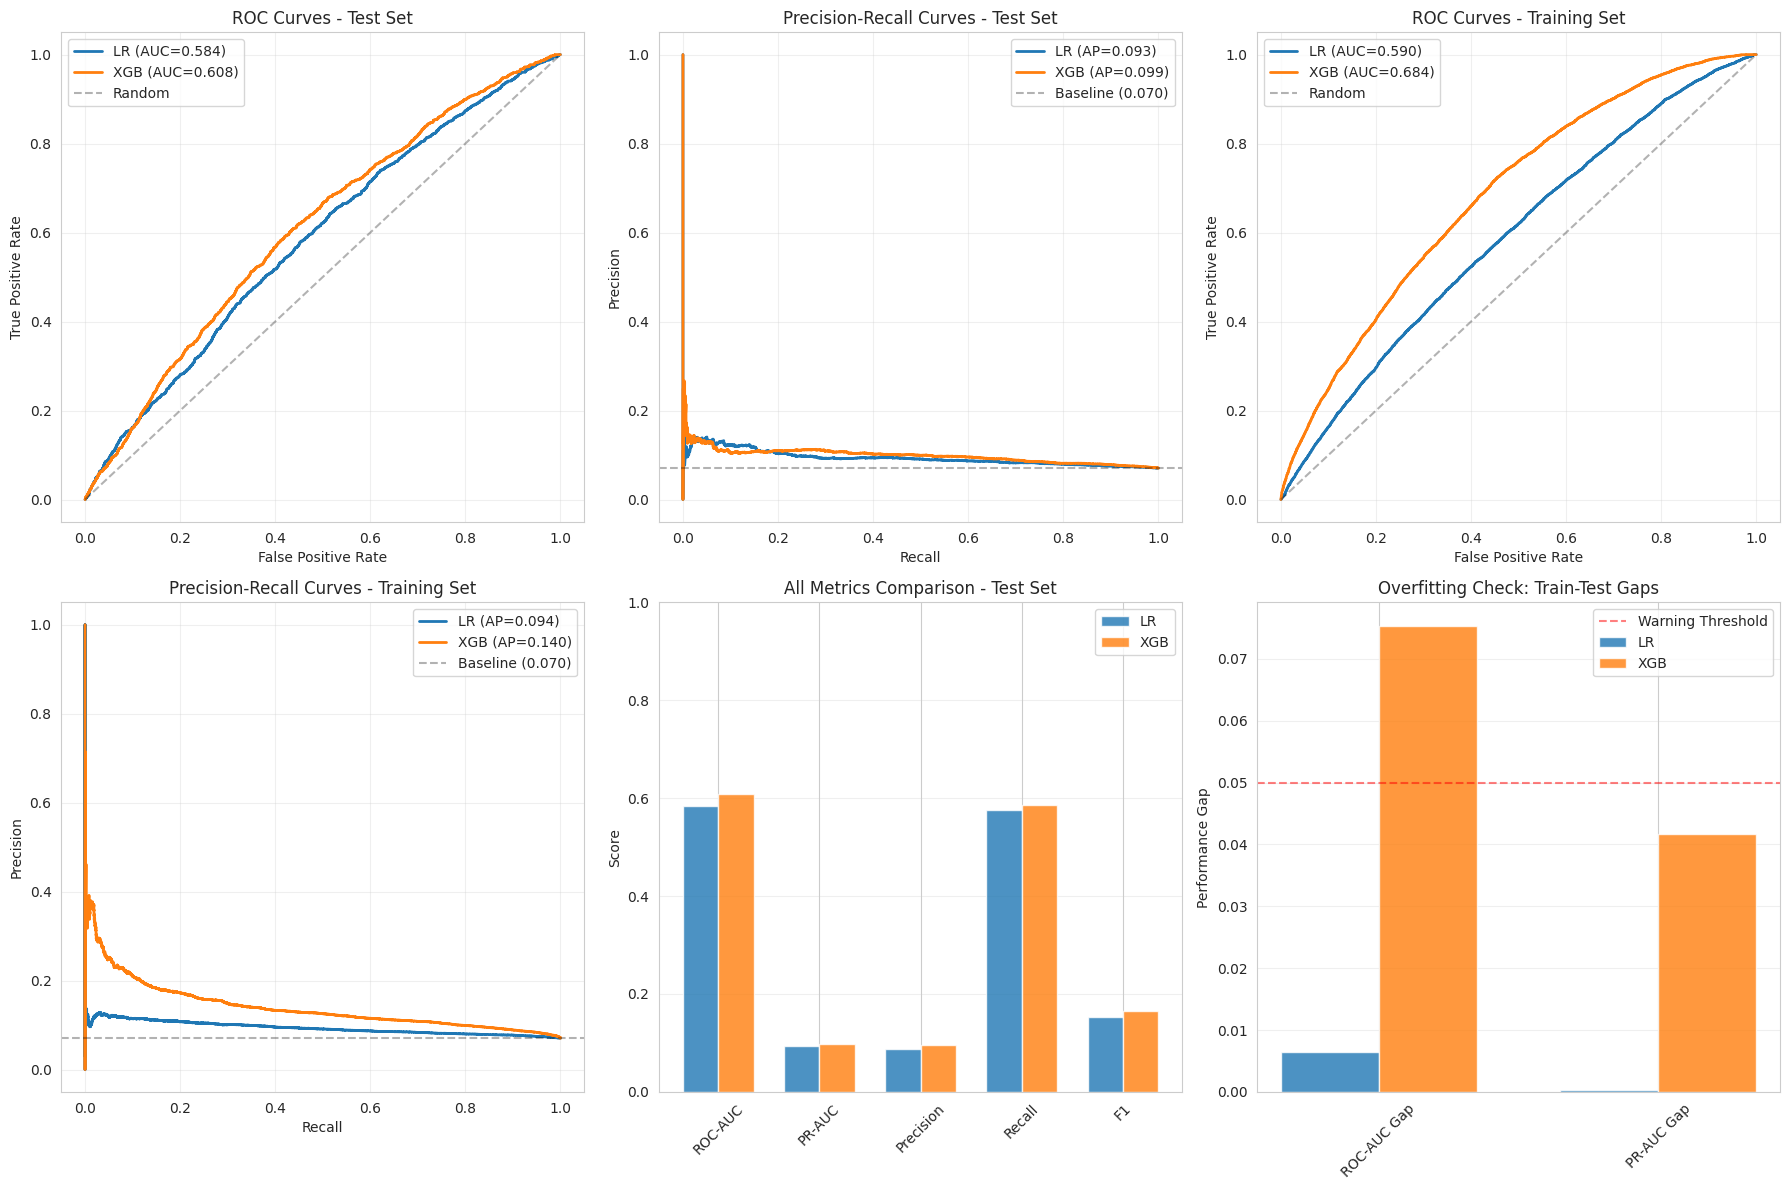

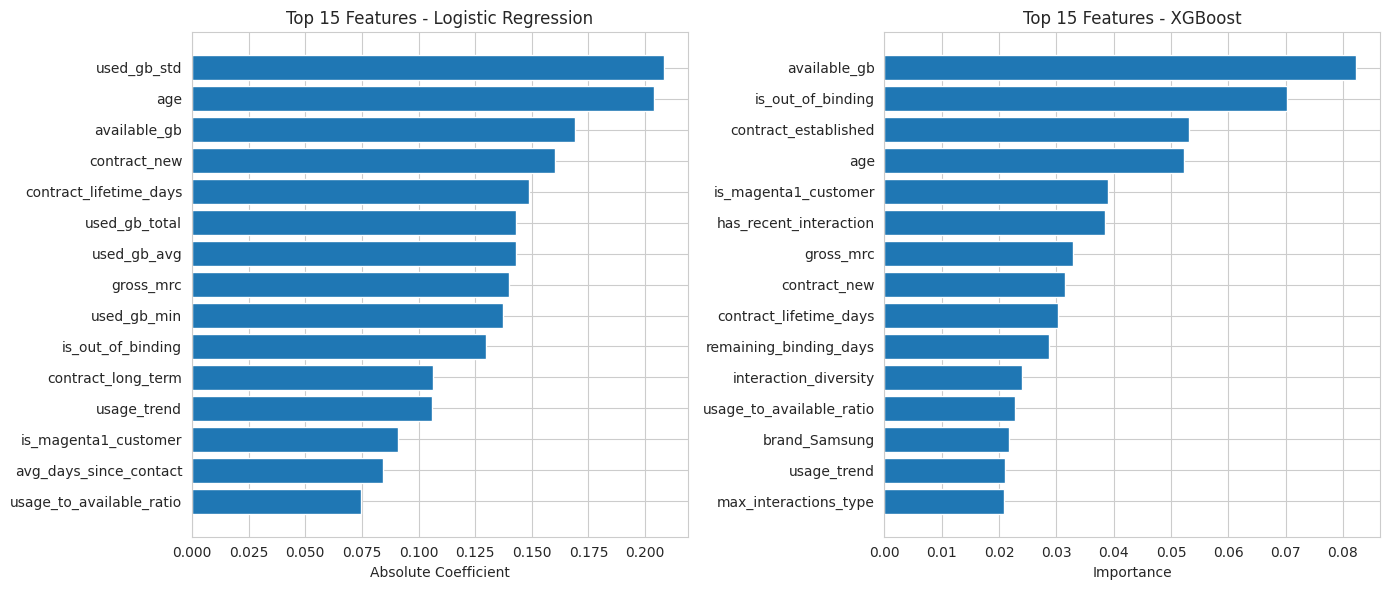


USING THE MODELS FOR PREDICTIONS

Top 10 Customers Most Likely to Upsell:
       predicted_probability  actual_upsell
13064               0.758737              0
57473               0.749469              0
14950               0.744124              0
9073                0.738423              1
10851               0.735562              0
13005               0.734627              0
90886               0.734519              0
2442                0.734236              0
94769               0.734227              1
44708               0.733480              0

Distribution of Predicted Probabilities:


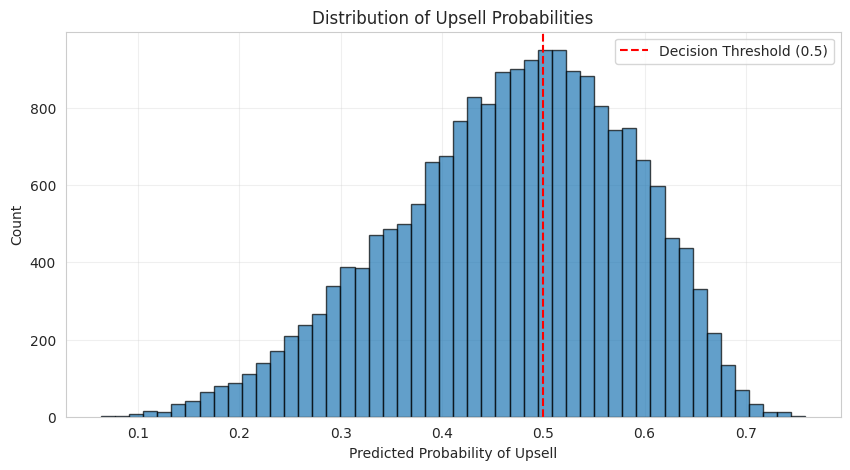


TARGETING STRATEGY:
Threshold 0.1: Target 19,992 customers, Expected conversion rate: 7.1%
Threshold 0.2: Target 19,667 customers, Expected conversion rate: 7.1%
Threshold 0.3: Target 18,184 customers, Expected conversion rate: 7.4%
Threshold 0.5: Target 8,568 customers, Expected conversion rate: 9.6%


In [11]:
if evaluate_lr is not None and evaluate_xgb is not None:
    print("\nCreating visualizations with PR curves...")
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. ROC Curves - Test Set
    fpr_lr, tpr_lr, _ = roc_curve(y_test, evaluate_lr['probabilities']) # type: ignore
    fpr_xgb, tpr_xgb, _ = roc_curve(y_test, evaluate_xgb['probabilities']) # type: ignore
    
    axes[0, 0].plot(fpr_lr, tpr_lr, label=f'LR (AUC={evaluate_lr["roc_auc"]:.3f})', linewidth=2)
    axes[0, 0].plot(fpr_xgb, tpr_xgb, label=f'XGB (AUC={evaluate_xgb["roc_auc"]:.3f})', linewidth=2)
    axes[0, 0].plot([0, 1], [0, 1], 'k--', label='Random', alpha=0.3)
    axes[0, 0].set_xlabel('False Positive Rate')
    axes[0, 0].set_ylabel('True Positive Rate')
    axes[0, 0].set_title('ROC Curves - Test Set')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. PR Curves - Test Set (NEW)
    precision_lr, recall_lr, _ = precision_recall_curve(y_test, evaluate_lr['probabilities']) # type: ignore
    precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, evaluate_xgb['probabilities']) # type: ignore
    baseline = y_test.mean() # type: ignore
    
    axes[0, 1].plot(recall_lr, precision_lr, label=f'LR (AP={lr_test_pr_auc:.3f})', linewidth=2) # type: ignore
    axes[0, 1].plot(recall_xgb, precision_xgb, label=f'XGB (AP={xgb_test_pr_auc:.3f})', linewidth=2) # type: ignore
    axes[0, 1].axhline(y=baseline, color='k', linestyle='--', label=f'Baseline ({baseline:.3f})', alpha=0.3)
    axes[0, 1].set_xlabel('Recall')
    axes[0, 1].set_ylabel('Precision')
    axes[0, 1].set_title('Precision-Recall Curves - Test Set')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. ROC Curves - Training Set
    fpr_lr_train, tpr_lr_train, _ = roc_curve(y_train, lr_train_pred_proba) # type: ignore
    fpr_xgb_train, tpr_xgb_train, _ = roc_curve(y_train, xgb_train_pred_proba) # type: ignore
    
    axes[0, 2].plot(fpr_lr_train, tpr_lr_train, label=f'LR (AUC={lr_train_auc:.3f})', linewidth=2) # type: ignore
    axes[0, 2].plot(fpr_xgb_train, tpr_xgb_train, label=f'XGB (AUC={xgb_train_auc:.3f})', linewidth=2) # type: ignore
    axes[0, 2].plot([0, 1], [0, 1], 'k--', label='Random', alpha=0.3)
    axes[0, 2].set_xlabel('False Positive Rate')
    axes[0, 2].set_ylabel('True Positive Rate')
    axes[0, 2].set_title('ROC Curves - Training Set')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. PR Curves - Training Set (NEW)
    precision_lr_train, recall_lr_train, _ = precision_recall_curve(y_train, lr_train_pred_proba) # type: ignore
    precision_xgb_train, recall_xgb_train, _ = precision_recall_curve(y_train, xgb_train_pred_proba) # type: ignore
    baseline_train = y_train.mean() # type: ignore
    
    axes[1, 0].plot(recall_lr_train, precision_lr_train, label=f'LR (AP={lr_train_pr_auc:.3f})', linewidth=2) # type: ignore
    axes[1, 0].plot(recall_xgb_train, precision_xgb_train, label=f'XGB (AP={xgb_train_pr_auc:.3f})', linewidth=2) # type: ignore
    axes[1, 0].axhline(y=baseline_train, color='k', linestyle='--', label=f'Baseline ({baseline_train:.3f})', alpha=0.3) # type: ignore
    axes[1, 0].set_xlabel('Recall')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].set_title('Precision-Recall Curves - Training Set')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 5. Metrics Comparison - Test Set
    metrics = ['ROC-AUC', 'PR-AUC', 'Precision', 'Recall', 'F1']
    lr_test_all = [
        evaluate_lr['roc_auc'],
        lr_test_pr_auc, # type: ignore
        evaluate_lr['confusion_matrix'][1,1] / (evaluate_lr['confusion_matrix'][1,1] + evaluate_lr['confusion_matrix'][0,1]),
        evaluate_lr['confusion_matrix'][1,1] / (evaluate_lr['confusion_matrix'][1,1] + evaluate_lr['confusion_matrix'][1,0]),
        evaluate_lr['f1_score']
    ]
    xgb_test_all = [
        evaluate_xgb['roc_auc'],
        xgb_test_pr_auc, # type: ignore
        evaluate_xgb['confusion_matrix'][1,1] / (evaluate_xgb['confusion_matrix'][1,1] + evaluate_xgb['confusion_matrix'][0,1]),
        evaluate_xgb['confusion_matrix'][1,1] / (evaluate_xgb['confusion_matrix'][1,1] + evaluate_xgb['confusion_matrix'][1,0]),
        evaluate_xgb['f1_score']
    ]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    axes[1, 1].bar(x - width/2, lr_test_all, width, label='LR', alpha=0.8)
    axes[1, 1].bar(x + width/2, xgb_test_all, width, label='XGB', alpha=0.8)
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].set_title('All Metrics Comparison - Test Set')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(metrics, rotation=45)
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    axes[1, 1].set_ylim([0, 1])
    
    # 6. Train vs Test Gap Comparison
    gap_metrics = ['ROC-AUC Gap', 'PR-AUC Gap']
    lr_gaps = [lr_train_auc - evaluate_lr['roc_auc'], lr_train_pr_auc - lr_test_pr_auc] # type: ignore
    xgb_gaps = [xgb_train_auc - evaluate_xgb['roc_auc'], xgb_train_pr_auc - xgb_test_pr_auc] # type: ignore
    
    x_gap = np.arange(len(gap_metrics))
    
    axes[1, 2].bar(x_gap - width/2, lr_gaps, width, label='LR', alpha=0.8)
    axes[1, 2].bar(x_gap + width/2, xgb_gaps, width, label='XGB', alpha=0.8)
    axes[1, 2].axhline(y=0.05, color='r', linestyle='--', label='Warning Threshold', alpha=0.5)
    axes[1, 2].set_ylabel('Performance Gap')
    axes[1, 2].set_title('Overfitting Check: Train-Test Gaps')
    axes[1, 2].set_xticks(x_gap)
    axes[1, 2].set_xticklabels(gap_metrics, rotation=45)
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Feature importance comparison
    if logistic_regression_model is not None and xgboost_model is not None:
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        # LR feature importance
        lr_imp = logistic_regression_model['feature_importance'].head(15)
        axes[0].barh(lr_imp['feature'], lr_imp['abs_coefficient'])
        axes[0].set_xlabel('Absolute Coefficient')
        axes[0].set_title('Top 15 Features - Logistic Regression')
        axes[0].invert_yaxis()
        
        # XGBoost feature importance
        xgb_imp = xgboost_model['feature_importance'].head(15)
        axes[1].barh(xgb_imp['feature'], xgb_imp['importance'])
        axes[1].set_xlabel('Importance')
        axes[1].set_title('Top 15 Features - XGBoost')
        axes[1].invert_yaxis()
        
        plt.tight_layout()
        plt.show()

# ============================================================================
# MAKE PREDICTIONS ON NEW DATA
# ============================================================================

print("\n" + "="*60)
print("USING THE MODELS FOR PREDICTIONS")
print("="*60)

if xgboost_model is not None and X_test is not None:
    # Get the model
    model = xgboost_model['model']
    
    # Make predictions
    predictions = model.predict_proba(X_test)[:, 1]
    
    # Create a results dataframe
    results_df = X_test.copy()
    results_df['actual_upsell'] = y_test.values # type: ignore
    results_df['predicted_probability'] = predictions
    results_df['predicted_class'] = (predictions > 0.5).astype(int)
    
    # Sort by probability (highest first) to see best targets
    results_df = results_df.sort_values('predicted_probability', ascending=False)
    
    print("\nTop 10 Customers Most Likely to Upsell:")
    print(results_df[['predicted_probability', 'actual_upsell']].head(10))
    
    print(f"\nDistribution of Predicted Probabilities:")
    plt.figure(figsize=(10, 5))
    plt.hist(predictions, bins=50, edgecolor='black', alpha=0.7)
    plt.xlabel('Predicted Probability of Upsell')
    plt.ylabel('Count')
    plt.title('Distribution of Upsell Probabilities')
    plt.axvline(x=0.5, color='red', linestyle='--', label='Decision Threshold (0.5)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Show targeting strategy
    print("\nTARGETING STRATEGY:")
    for threshold in [0.1, 0.2, 0.3, 0.5]:
        n_targeted = (predictions >= threshold).sum()
        if n_targeted > 0:
            precision_at_thresh = y_test[predictions >= threshold].mean() # type: ignore
            print(f"Threshold {threshold:.1f}: Target {n_targeted:,} customers, "
                  f"Expected conversion rate: {precision_at_thresh:.1%}")

